[*********************100%***********************]  10 of 10 completed


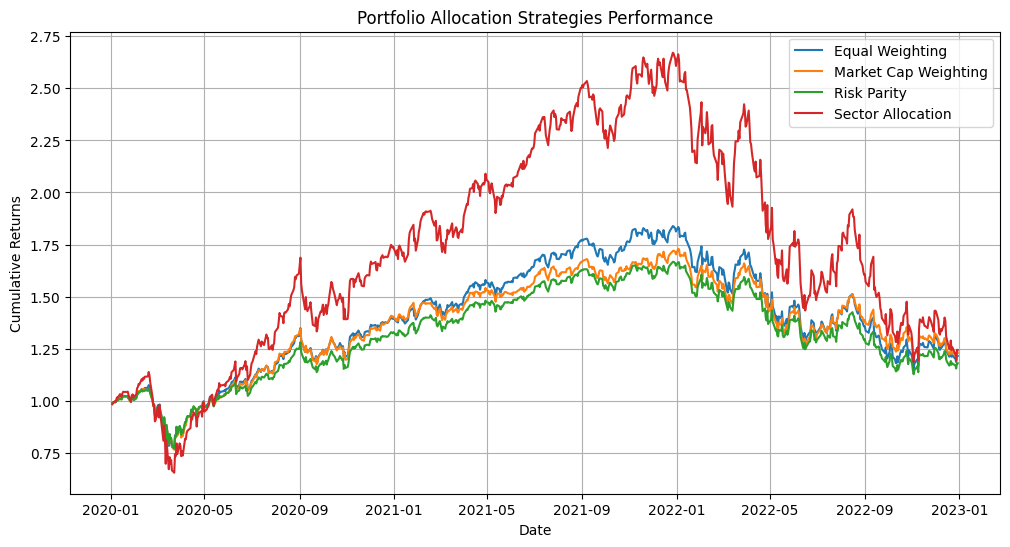

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'AMZN', 'GOOGL', 'NVDA', 'VZ', 'DIS', 'META']
start_date = '2020-01-01'
end_date = '2023-01-01'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()

def equal_weighting(returns):
    n = len(returns.columns)
    weights = np.array([1/n] * n)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def market_cap_weighting(tickers):
    market_caps = np.array([2500, 2000, 500, 450, 1800, 1600, 700, 230, 170, 600])
    weights = market_caps / market_caps.sum()
    return weights

def portfolio_returns_market_cap(returns):
    weights = market_cap_weighting(tickers)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def risk_parity(returns):
    cov_matrix = returns.cov()
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / inv_vol.sum()
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def sector_allocation(returns, sector_weights):
    sector_mapping = [0, 0, 1, 2, 3, 4, 1, 4, 3, 4]

    ticker_weights = [sector_weights[sector_index] for sector_index in sector_mapping]

    weights = np.array(ticker_weights)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

sector_weights = [0.25, 0.15, 0.20, 0.15, 0.10, 0.15]


equal_weighted_returns = equal_weighting(returns)
market_cap_weighted_returns = portfolio_returns_market_cap(returns)
risk_parity_returns = risk_parity(returns)
sector_weighted_returns = sector_allocation(returns, sector_weights)


portfolio_results = pd.DataFrame({
    'Equal Weighting': equal_weighted_returns,
    'Market Cap Weighting': market_cap_weighted_returns,
    'Risk Parity': risk_parity_returns,
    'Sector Allocation': sector_weighted_returns
})


cumulative_returns = (1 + portfolio_results).cumprod()


plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns)
plt.title('Portfolio Allocation Strategies Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(portfolio_results.columns)
plt.grid()
plt.show()


[*********************100%***********************]  10 of 10 completed


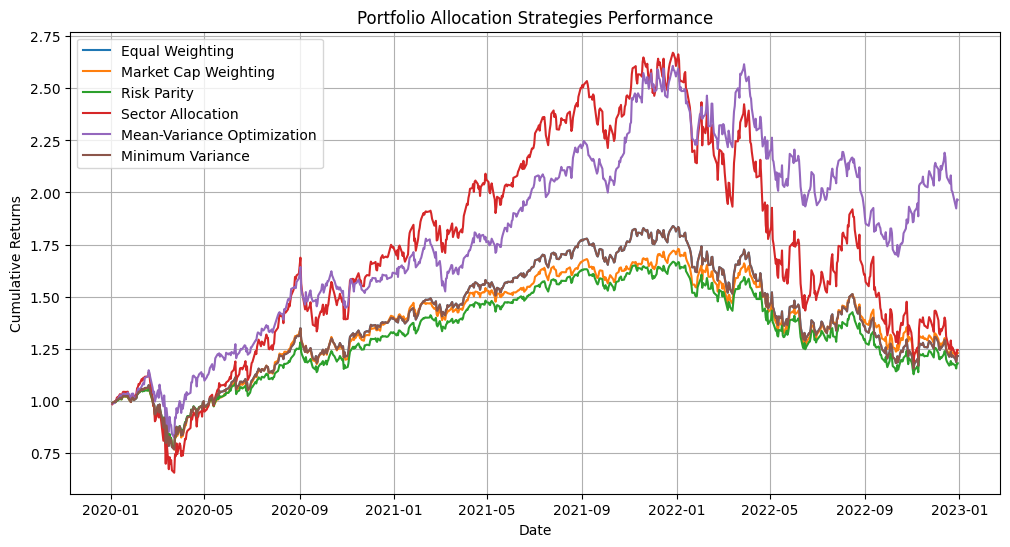

                            Annualized Return  Annualized Volatility  \
Equal Weighting                      0.104997               0.282303   
Market Cap Weighting                 0.104509               0.266654   
Risk Parity                          0.087453               0.253758   
Sector Allocation                    0.183507               0.469242   
Mean-Variance Optimization           0.276798               0.320641   
Minimum Variance                     0.104997               0.282303   

                            Sharpe Ratio  
Equal Weighting                 0.371931  
Market Cap Weighting            0.391926  
Risk Parity                     0.344631  
Sector Allocation               0.391070  
Mean-Variance Optimization      0.863263  
Minimum Variance                0.371931  


In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'AMZN', 'GOOGL', 'NVDA', 'VZ', 'DIS', 'META']
end_date = '2023-01-01'


data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()


def equal_weighting(returns):
    n = len(returns.columns)
    weights = np.array([1/n] * n)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns


def market_cap_weighting(tickers):

    market_caps = np.array([2500, 2000, 500, 450, 1800, 1600, 700, 230, 170, 600])
    return weights

def portfolio_returns_market_cap(returns):
    weights = market_cap_weighting(tickers)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def risk_parity(returns):
    cov_matrix = returns.cov()
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / inv_vol.sum()
    portfolio_returns = returns.dot(weights)
    return portfolio_returns


def sector_allocation(returns, sector_weights):
    sector_mapping = [0, 0, 1, 2, 3, 4, 1, 4, 3, 4]
    ticker_weights = [sector_weights[sector_index] for sector_index in sector_mapping]
    weights = np.array(ticker_weights)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def mean_variance_optimization(returns):
    def objective(weights):
        return -returns.mean().dot(weights) / np.sqrt(weights.dot(returns.cov()).dot(weights))

    n = len(returns.columns)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.array(n * [1. / n])

    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def portfolio_returns_mean_variance(returns):
    weights = mean_variance_optimization(returns)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def black_litterman(returns, market_weights, omega, P, Q):
    tau = 0.05
    cov_matrix = returns.cov().values
    pi = market_weights.dot(cov_matrix)
    P = P.reshape(-1, len(tickers))
    Q = Q.reshape(-1, 1)

    term1 = np.linalg.inv(np.linalg.inv(tau * cov_matrix) + P.T @ np.linalg.inv(omega) @ P)
    term2 = np.linalg.inv(tau * cov_matrix) @ pi + P.T @ np.linalg.inv(omega) @ Q

    ER = term1 @ term2

    weights = np.maximum(ER, 0)
    weights /= np.sum(weights)

    return weights

def portfolio_returns_black_litterman(returns):
    market_weights = market_cap_weighting(tickers)
    omega = np.diag(np.array([0.1] * len(tickers)))
    P = np.array([[1, -1, 0, 0, 0, 0, 0, 0, 0, 0]])
    Q = np.array([0.02])
    weights = black_litterman(returns, market_weights, omega, P, Q)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns


def minimum_variance_portfolio(returns):
    n = len(returns.columns)
    cov_matrix = returns.cov().values

    def objective(weights):
        return weights.dot(cov_matrix).dot(weights)

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.array(n * [1. / n])

    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def portfolio_returns_minimum_variance(returns):
    weights = minimum_variance_portfolio(returns)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

sector_weights = [0.25, 0.15, 0.20, 0.15, 0.10, 0.15]
equal_weighted_returns = equal_weighting(returns)
market_cap_weighted_returns = portfolio_returns_market_cap(returns)
risk_parity_returns = risk_parity(returns)
sector_weighted_returns = sector_allocation(returns, sector_weights)
mean_variance_returns = portfolio_returns_mean_variance(returns)
#black_litterman_returns = portfolio_returns_black_litterman(returns)
minimum_variance_returns = portfolio_returns_minimum_variance(returns)

portfolio_results = pd.DataFrame({
    'Equal Weighting': equal_weighted_returns,
    'Market Cap Weighting': market_cap_weighted_returns,
    'Risk Parity': risk_parity_returns,
    'Sector Allocation': sector_weighted_returns,
    'Mean-Variance Optimization': mean_variance_returns,
    #'Black-Litterman': black_litterman_returns,
    'Minimum Variance': minimum_variance_returns
})

cumulative_returns = (1 + portfolio_results).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns)
plt.title('Portfolio Allocation Strategies Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(portfolio_results.columns)
plt.grid()
plt.show()

def calculate_metrics(returns):
    metrics = {}
    metrics['Annualized Return'] = np.mean(returns) * 252
    metrics['Annualized Volatility'] = np.std(returns) * np.sqrt(252)
    metrics['Sharpe Ratio'] = metrics['Annualized Return'] / metrics['Annualized Volatility']
    return metrics

metrics_results = {}
for strategy in portfolio_results.columns:
    metrics_results[strategy] = calculate_metrics(portfolio_results[strategy])

metrics_df = pd.DataFrame(metrics_results).T
print(metrics_df)


[*********************100%***********************]  10 of 10 completed


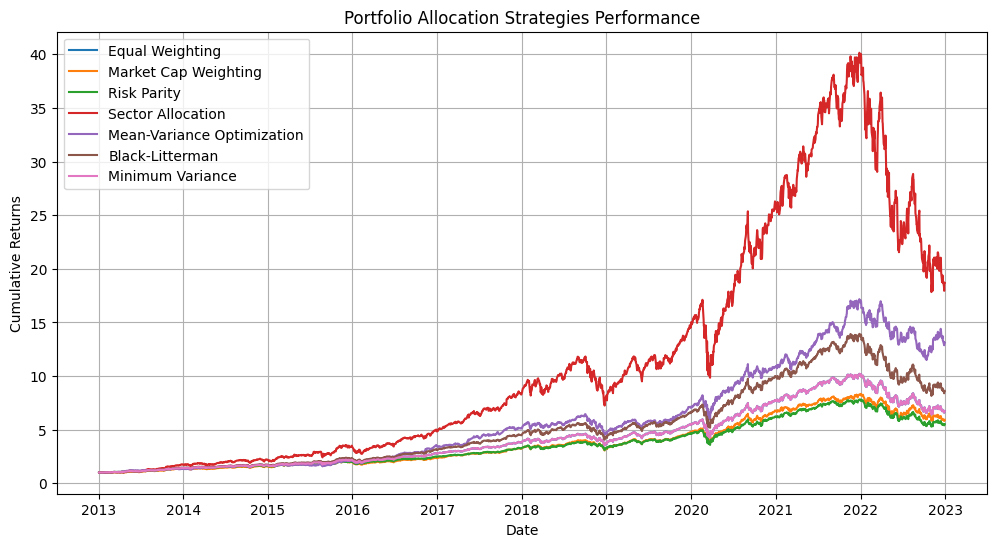

                            Annualized Return  Annualized Volatility  \
Equal Weighting                      0.211870               0.203433   
Market Cap Weighting                 0.197515               0.196671   
Risk Parity                          0.188122               0.185310   
Sector Allocation                    0.351553               0.340447   
Mean-Variance Optimization           0.283874               0.228099   
Black-Litterman                      0.241634               0.227031   
Minimum Variance                     0.211870               0.203433   

                            Sharpe Ratio  
Equal Weighting                 1.041473  
Market Cap Weighting            1.004293  
Risk Parity                     1.015176  
Sector Allocation               1.032622  
Mean-Variance Optimization      1.244523  
Black-Litterman                 1.064323  
Minimum Variance                1.041473  


In [53]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'AMZN', 'GOOGL', 'NVDA', 'VZ', 'DIS', 'META']
start_date = '2013-01-01'
end_date = '2023-01-01'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()

def equal_weighting(returns):
    n = len(returns.columns)
    weights = np.array([1/n] * n)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def market_cap_weighting(tickers):
    market_caps = np.array([2500, 2000, 500, 450, 1800, 1600, 700, 230, 170, 600])
    weights = market_caps / market_caps.sum()
    return weights

def portfolio_returns_market_cap(returns):
    weights = market_cap_weighting(tickers)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def risk_parity(returns):
    cov_matrix = returns.cov()
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / inv_vol.sum()
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def sector_allocation(returns, sector_weights):
    sector_mapping = [0, 0, 1, 2, 3, 4, 1, 4, 3, 4]
    ticker_weights = [sector_weights[sector_index] for sector_index in sector_mapping]
    weights = np.array(ticker_weights)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def mean_variance_optimization(returns):
    def objective(weights):
        return -returns.mean().dot(weights) / np.sqrt(weights.dot(returns.cov()).dot(weights))

    n = len(returns.columns)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.array(n * [1. / n])

    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def portfolio_returns_mean_variance(returns):
    weights = mean_variance_optimization(returns)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

def black_litterman(returns, market_weights, views=None):
    tau = 0.05
    n_assets = len(returns.columns)
    cov_matrix = returns.cov().values
    pi = market_weights.dot(cov_matrix)

    if views is None:
        P = np.zeros((1, n_assets))
        P[0, 0] = 1
        P[0, 1] = -1

        Q = np.array([[0.02]])

        omega = np.diag([0.01])
    else:
        P = views['P']
        Q = views['Q']
        omega = views['omega']

    pi = pi.reshape(-1, 1)
    term1 = np.linalg.inv(
        np.linalg.inv(tau * cov_matrix) +
        P.T @ np.linalg.inv(omega) @ P
    )

    term2 = (
        np.linalg.inv(tau * cov_matrix) @ pi +
        P.T @ np.linalg.inv(omega) @ Q
    )

    posterior_returns = term1 @ term2

    weights = posterior_returns.flatten()

    weights = np.maximum(weights, 0)
    weights = weights / weights.sum()

    return weights

def portfolio_returns_black_litterman(returns):
    market_weights = market_cap_weighting(tickers)

    views = {
        'P': np.array([[1, -1] + [0] * 8]),
        'Q': np.array([[0.02]]),
        'omega': np.diag([0.01])
    }

    weights = black_litterman(returns, market_weights, views)
    portfolio_returns = returns.dot(weights)

    return portfolio_returns



def minimum_variance_portfolio(returns):
    n = len(returns.columns)
    cov_matrix = returns.cov().values

    def objective(weights):
        return weights.dot(cov_matrix).dot(weights)

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.array(n * [1. / n])

    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def portfolio_returns_minimum_variance(returns):
    weights = minimum_variance_portfolio(returns)
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

sector_weights = [0.25, 0.15, 0.20, 0.15, 0.10, 0.15]
equal_weighted_returns = equal_weighting(returns)
market_cap_weighted_returns = portfolio_returns_market_cap(returns)
risk_parity_returns = risk_parity(returns)
sector_weighted_returns = sector_allocation(returns, sector_weights)
mean_variance_returns = portfolio_returns_mean_variance(returns)
black_litterman_returns = portfolio_returns_black_litterman(returns)
minimum_variance_returns = portfolio_returns_minimum_variance(returns)

portfolio_results = pd.DataFrame({
    'Equal Weighting': equal_weighted_returns,
    'Market Cap Weighting': market_cap_weighted_returns,
    'Risk Parity': risk_parity_returns,
    'Sector Allocation': sector_weighted_returns,
    'Mean-Variance Optimization': mean_variance_returns,
    'Black-Litterman': black_litterman_returns,
    'Minimum Variance': minimum_variance_returns
})

cumulative_returns = (1 + portfolio_results).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns)
plt.title('Portfolio Allocation Strategies Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(portfolio_results.columns)
plt.grid()
plt.show()

def calculate_metrics(returns):
    metrics = {}
    metrics['Annualized Return'] = np.mean(returns) * 252
    metrics['Annualized Volatility'] = np.std(returns) * np.sqrt(252)
    metrics['Sharpe Ratio'] = metrics['Annualized Return'] / metrics['Annualized Volatility']
    return metrics

metrics_results = {}
for strategy in portfolio_results.columns:
    metrics_results[strategy] = calculate_metrics(portfolio_results[strategy])

metrics_df = pd.DataFrame(metrics_results).T
print(metrics_df)


In [48]:
pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.4 MB/s eta 0:00:00


In [49]:
import random
from deap import base, creator, tools

def evalPortfolio(weights):
    portfolio_return = (returns.dot(weights)).mean() * 252
    portfolio_volatility = np.std(returns.dot(weights)) * np.sqrt(252)
    sharpe_ratio = portfolio_return / portfolio_volatility
    return sharpe_ratio,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize population
def initPopulation(size):
    population = []
    for _ in range(size):
        individual = [random.uniform(0, 1) for _ in range(len(tickers))]
        individual = np.array(individual) / np.sum(individual)  # Normalize weights
        population.append(creator.Individual(individual))
    return population

population = initPopulation(100)

# Genetic Algorithm operators
toolbox = base.Toolbox()
toolbox.register("evaluate", evalPortfolio)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

NGEN = 50
for gen in range(NGEN):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

best_individual = tools.selBest(population, 1)[0]
optimal_weights_ga = np.array(best_individual)


In [50]:
class Particle:
    def __init__(self, n):
        self.position = np.random.dirichlet(np.ones(n), size=1)[0]
        self.velocity = np.random.rand(n) * 0.1
        self.best_position = np.copy(self.position)
        self.best_value = -np.inf

def pso(num_particles, num_iterations):
    particles = [Particle(len(tickers)) for _ in range(num_particles)]
    global_best_position = None
    global_best_value = -np.inf

    for _ in range(num_iterations):
        for particle in particles:
            current_value = evalPortfolio(particle.position)[0]

            if current_value > particle.best_value:
                particle.best_value = current_value
                particle.best_position = np.copy(particle.position)

            if current_value > global_best_value:
                global_best_value = current_value
                global_best_position = np.copy(particle.position)

            inertia = 0.7
            cognitive_component = 1.5 * random.random() * (particle.best_position - particle.position)
            social_component = 1.5 * random.random() * (global_best_position - particle.position)
            particle.velocity = inertia * particle.velocity + cognitive_component + social_component
            particle.position += particle.velocity
            particle.position = np.clip(particle.position, 0, 1)
            particle.position /= np.sum(particle.position)

    return global_best_position

optimal_weights_pso = pso(num_particles=30, num_iterations=50)


In [59]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

def fractal_analysis(returns):
    def rs_analysis(ts):
        ts = np.array(ts.dropna())
        if len(ts) < 100:
            return np.nan

        max_k = int(np.floor(len(ts)/2))
        windows = list(range(10, max_k, 10))

        rs_values = []
        for window in windows:
            n_chunks = int(len(ts) / window)
            if n_chunks < 1:
                continue

            chunk_rs = []
            for i in range(n_chunks):
                chunk = ts[i * window: (i + 1) * window]
                if len(chunk) < window:
                    continue

                mean_adj = chunk - np.mean(chunk)
                cum_dev = np.cumsum(mean_adj)
                r = np.max(cum_dev) - np.min(cum_dev)
                s = np.std(chunk)

                if s > 0:
                    chunk_rs.append(r/s)

            if chunk_rs:
                rs_values.append(np.mean(chunk_rs))

        if len(rs_values) < 2:
            return np.nan

        x = np.log10(windows[:len(rs_values)])
        y = np.log10(rs_values)

        slope, _, r_value, _, _ = stats.linregress(x, y)

        if r_value**2 >= 0.5:
            return slope
        else:
            return np.nan

    results = pd.Series(index=returns.columns)
    for col in returns.columns:
        results[col] = rs_analysis(returns[col])

    def interpret_hurst(h):
        if np.isnan(h):
            return "Unable to calculate"
        elif h < 0.45:
            return f"{h:.3f} - Strong mean reversion"
        elif h < 0.5:
            return f"{h:.3f} - Mean reversion tendency"
        elif 0.45 <= h <= 0.55:
            return f"{h:.3f} - Random walk"
        elif h > 0.55:
            return f"{h:.3f} - Trend following"
        else:
            return f"{h:.3f} - Strong trend following"

    interpretations = results.apply(interpret_hurst)

    return pd.DataFrame({
        'Hurst Exponent': results,
        'Interpretation': interpretations
    })

if __name__ == "__main__":
    tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'META']

    # Download daily data for the last 10 years
    data = yf.download(tickers,
                      start="2004-01-01",
                      end="2024-01-01",
                      progress=False)['Adj Close']

    # Calculate log returns
    returns = np.log(data/data.shift(1)).dropna()

    # Run fractal analysis
    results = fractal_analysis(returns)
    print("\nFractal Analysis Results:")
    print(results)

    # Additional statistics
    print("\nData Statistics:")
    print(f"Number of observations: {len(returns)}")
    print("\nReturn Statistics:")
    print(returns.describe())


Fractal Analysis Results:
        Hurst Exponent                   Interpretation
Ticker                                                 
AAPL          0.535594              0.536 - Random walk
AMZN          0.507388              0.507 - Random walk
GOOGL         0.478954  0.479 - Mean reversion tendency
META          0.546578              0.547 - Random walk
MSFT          0.403188    0.403 - Strong mean reversion

Data Statistics:
Number of observations: 2922

Return Statistics:
Ticker         AAPL         AMZN        GOOGL         META         MSFT
count   2922.000000  2922.000000  2922.000000  2922.000000  2922.000000
mean       0.000850     0.000908     0.000763     0.000762     0.000948
std        0.017921     0.020331     0.017033     0.025337     0.016752
min       -0.137708    -0.151398    -0.123685    -0.306391    -0.159454
25%       -0.007549    -0.008771    -0.007117    -0.010096    -0.006808
50%        0.000889     0.000935     0.000784     0.000998     0.000734
75%       


Fractal Analysis Results:
        Hurst Exponent                   Interpretation
Ticker                                                 
AAPL          0.535594              0.536 - Random walk
AMZN          0.507388              0.507 - Random walk
DIS           0.524624              0.525 - Random walk
GOOGL         0.478954  0.479 - Mean reversion tendency
JNJ           0.476214  0.476 - Mean reversion tendency
JPM           0.507633              0.508 - Random walk
META          0.546578              0.547 - Random walk
MSFT          0.403188    0.403 - Strong mean reversion
NVDA          0.584693          0.585 - Trend following
VZ            0.445732    0.446 - Strong mean reversion

Data Statistics:
Number of observations: 2922

Return Statistics:
Ticker         AAPL         AMZN          DIS        GOOGL          JNJ  \
count   2922.000000  2922.000000  2922.000000  2922.000000  2922.000000   
mean       0.000850     0.000908     0.000286     0.000763     0.000423   
std      

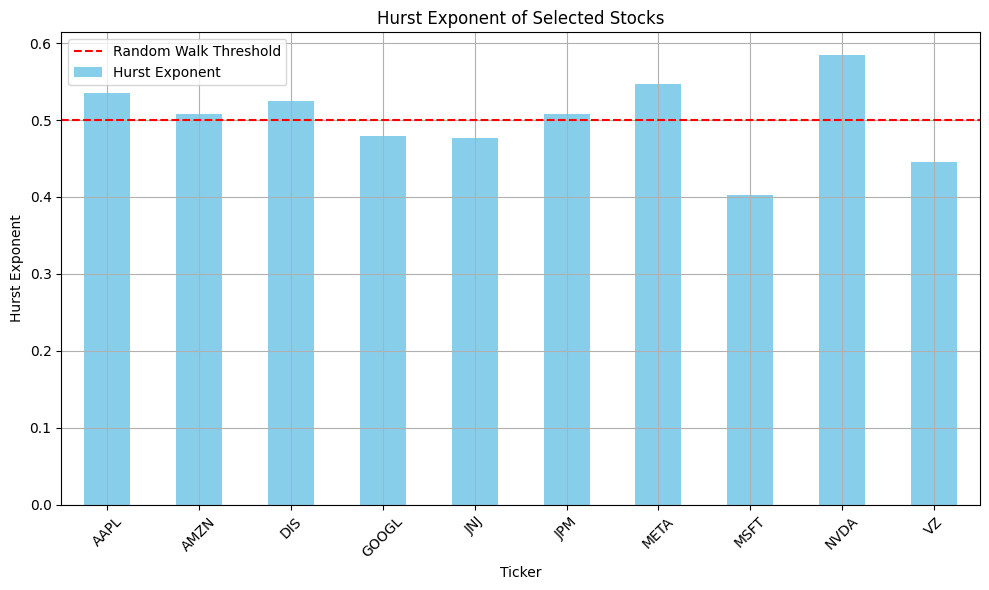

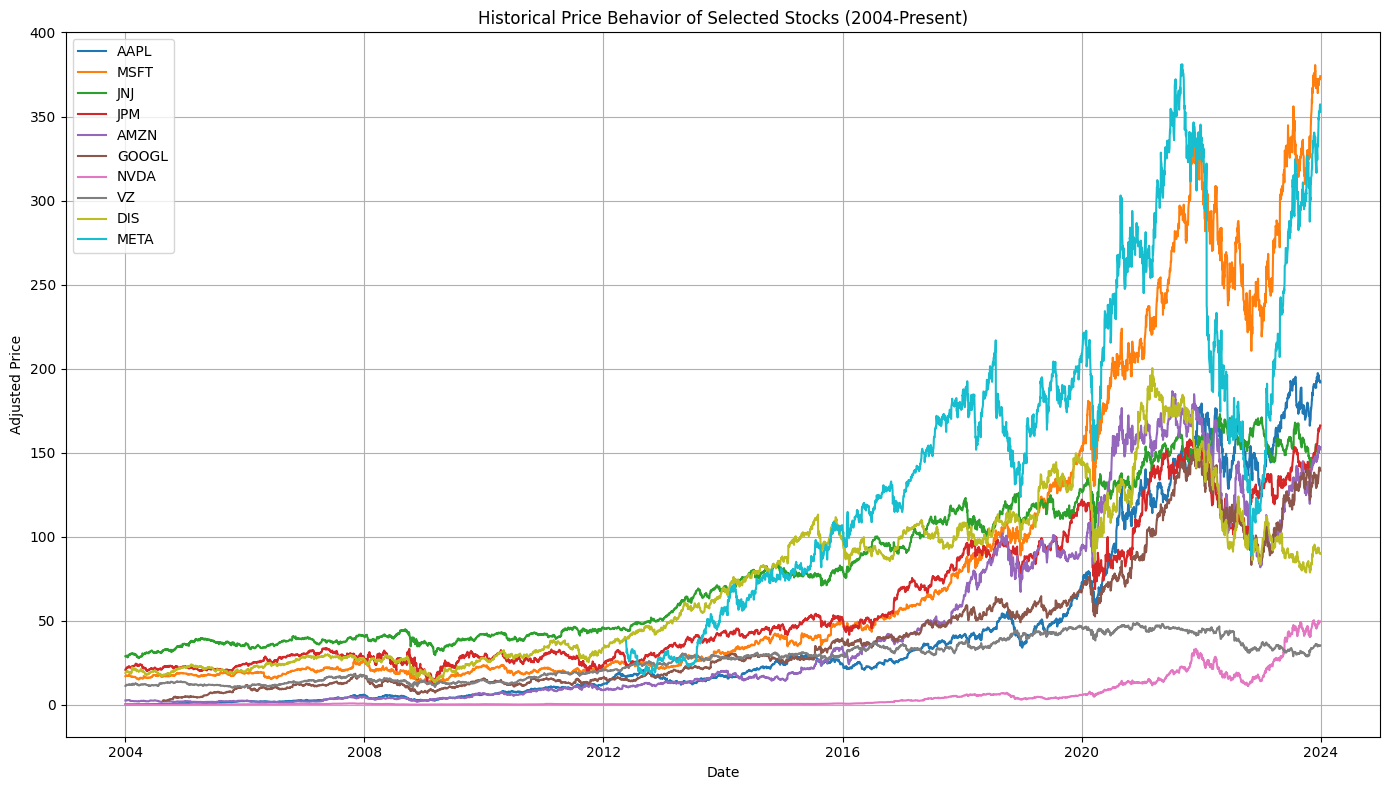

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def fractal_analysis(returns):
    """
    Calculate the Hurst exponent for financial time series using R/S analysis

    Parameters:
    returns: pandas DataFrame of returns

    Returns:
    pandas DataFrame with Hurst exponents and interpretations
    """
    def rs_analysis(ts):
        ts = np.array(ts.dropna())
        if len(ts) < 100:
            return np.nan

        max_k = int(np.floor(len(ts) / 2))
        windows = list(range(10, max_k, 10))

        rs_values = []
        for window in windows:
            n_chunks = int(len(ts) / window)
            if n_chunks < 1:
                continue

            chunk_rs = []
            for i in range(n_chunks):
                chunk = ts[i * window: (i + 1) * window]
                if len(chunk) < window:
                    continue

                mean_adj = chunk - np.mean(chunk)
                cum_dev = np.cumsum(mean_adj)
                r = np.max(cum_dev) - np.min(cum_dev)
                s = np.std(chunk)

                if s > 0:
                    chunk_rs.append(r / s)

            if chunk_rs:
                rs_values.append(np.mean(chunk_rs))

        if len(rs_values) < 2:
            return np.nan

        x = np.log10(windows[:len(rs_values)])
        y = np.log10(rs_values)

        slope, _, r_value, _, _ = stats.linregress(x, y)

        if r_value**2 >= 0.5:
            return slope
        else:
            return np.nan

    results = pd.Series(index=returns.columns)
    for col in returns.columns:
        results[col] = rs_analysis(returns[col])

    def interpret_hurst(h):
        if np.isnan(h):
            return "Unable to calculate"
        elif h < 0.45:
            return f"{h:.3f} - Strong mean reversion"
        elif h < 0.5:
            return f"{h:.3f} - Mean reversion tendency"
        elif 0.45 <= h <= 0.55:
            return f"{h:.3f} - Random walk"
        elif h > 0.55:
            return f"{h:.3f} - Trend following"
        else:
            return f"{h:.3f} - Strong trend following"

    interpretations = results.apply(interpret_hurst)

    return pd.DataFrame({
        'Hurst Exponent': results,
        'Interpretation': interpretations
    })

def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return the p-value

if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'AMZN', 'GOOGL', 'NVDA', 'VZ', 'DIS', 'META']

    data = yf.download(tickers,
                      start="2004-01-01",
                      end="2024-01-01",
                      progress=False)['Adj Close']

    returns = np.log(data / data.shift(1)).dropna()

    # Run fractal analysis
    results = fractal_analysis(returns)
    print("\nFractal Analysis Results:")
    print(results)

    print("\nData Statistics:")
    print(f"Number of observations: {len(returns)}")
    print("\nReturn Statistics:")
    print(returns.describe())

    print("\nAugmented Dickey-Fuller Test Results:")
    for ticker in tickers:
        p_value = adf_test(returns[ticker])
        print(f"{ticker}: p-value = {p_value:.4f} - {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")

    plt.figure(figsize=(10, 6))
    results['Hurst Exponent'].plot(kind='bar', color='skyblue')
    plt.axhline(0.5, color='red', linestyle='--', label='Random Walk Threshold')
    plt.title('Hurst Exponent of Selected Stocks')
    plt.ylabel('Hurst Exponent')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 8))
    for ticker in tickers:
        plt.plot(data.index, data[ticker], label=ticker)

    plt.title('Historical Price Behavior of Selected Stocks (2004-Present)')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
